In [1]:
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
# import dask
# import dask.distributed
# import ncar_jobqueue
import esmlab
import esmlab_regrid
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from netCDF4 import default_fillvals
import pop_tools 

import config

import warnings
from datetime import date, datetime, timezone


### Prep work
set up directory with original and destination grid files in it

In [2]:
USER = os.environ['USER']
gridfile_directory = esmlab.config.set({'regrid.gridfile-directory': f'/glade/work/{USER}/esmlab-regrid'})
esmlab.config.get('regrid.gridfile-directory')

'/glade/work/kristenk/esmlab-regrid'

In [3]:
method = 'conservative'
src_grid = 'latlon_1x1_180W'
dst_grid = 'POP_gx3v7'
ltripole = False

regrid_operator = esmlab_regrid.regridder(name_grid_src=src_grid, 
                                          name_grid_dst=dst_grid, 
                                          method=method, overwrite_existing=False)

/glade/work/kristenk/esmlab-regrid
/glade/work/kristenk/esmlab-regrid


In [4]:
ds_dst = pop_tools.get_grid(grid_name=dst_grid)
ds_dst

<xarray.Dataset>
Dimensions:      (nlat: 116, nlon: 100, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
    TLONG        (nlat, nlon) float64 323.3 326.9 330.5 ... 317.8 319.3 320.8
    ULAT         (nlat, nlon) float64 -78.73 -78.73 -78.73 ... 68.49 68.42 68.4
    ULONG        (nlat, nlon) float64 325.1 328.7 332.3 ... 318.7 320.1 321.5
    DXT          (nlat, nlon) float64 7.302e+06 7.302e+06 ... 6.129e+06
    DYT          (nlat, nlon) float64 1.686e+07 1.686e+07 ... 4.524e+06
    TAREA        (nlat, nlon) float64 1.231e+14 1.231e+14 ... 2.773e+13
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 

### Read in CHL

In [5]:
file='/glade/work/kristenk/satellite_data/processed/CHL_mean2003to2018_1deg.nc'

In [6]:
dsann = xr.open_dataset(file, decode_times=False)
#attrs = dsann.attrs

In [9]:
dsann = dsann.rename({'z':'CHL'})

In [12]:
v='CHL'

In [13]:
dsann

<xarray.Dataset>
Dimensions:  (x: 360, y: 180)
Coordinates:
  * x        (x) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5 179.5
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    CHL      (y, x) float32 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        data.grd
    history:      grdmath data.grd 1 MUL = CHL_mean2003to2018_1deg.nc
    GMT_version:  4.5.18 [64-bit]
    node_offset:  1

### Regrid laterally

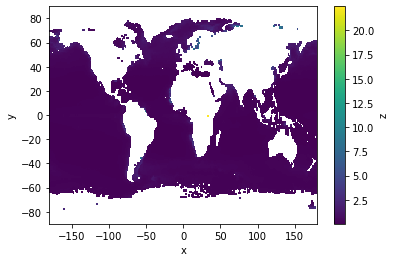

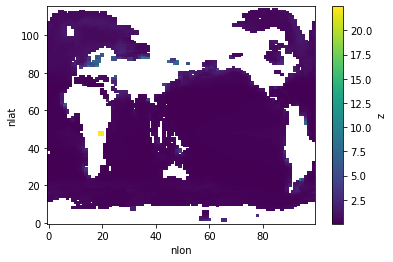

In [15]:
dso_lateral = xr.Dataset()

dso_lateral[v] = regrid_operator(dsann[v], renormalize=True)

dso_lateral = dso_lateral.rename({'x': 'nlon', 'y': 'nlat'})

plt.figure()
dsann[v].plot()

plt.figure()
dso_lateral[v].plot();

In [18]:
dso_lateral

<xarray.Dataset>
Dimensions:  (nlat: 116, nlon: 100)
Dimensions without coordinates: nlat, nlon
Data variables:
    CHL      (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan

### Get the dataset ready to write out

In [17]:
dso = dso_lateral.copy()

dso[v].encoding['_FillValue'] = default_fillvals['f4']
dso[v].encoding['dtype'] = np.float32
    
for v in ds_dst.variables:
    dso[v] = ds_dst[v]
    
for v in dso.variables:
    if '_FillValue' not in dso[v].encoding:
        dso[v].encoding['_FillValue'] = None
    
datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
dso.attrs['history'] = f'created by kristen krumhardt on {datestamp}'

datestamp = date.today().strftime("%y%m%d")
dso

<xarray.Dataset>
Dimensions:      (nlat: 116, nlon: 100, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    CHL          (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
    TLAT         (nlat, nlon) float64 -79.5 -79.5 -79.5 ... 68.36 68.26 68.21
    TLONG        (nlat, nlon) float64 323.3 326.9 330.5 ... 317.8 319.3 320.8
    ULAT         (nlat, nlon) float64 -78.73 -78.73 -78.73 ... 68.49 68.42 68.4
    ULONG        (nlat, nlon) float64 325.1 328.7 332.3 ... 318.7 320.1 321.5
    DXT          (nlat, nlon) float64 7.302e+06 7.302e+06 ... 6.129e+06
    DYT          (nlat, nlon) float64 1.686e+07 1.686e+07 ... 4.524e+06
    TAREA        (nlat, nlon) float64 1.231e+14 1.231e+14 ... 2.77

In [25]:
#!ncdump -h /glade/work/kristenk/WOA_data/regrid_POP/WOA_POPgrid.nc

In [21]:
#file_out = f'{config.dirout}/marbl_jan_ic_woa_{dst_grid}.c{datestamp}.nc'
file_out = '/glade/work/kristenk/satellite_data/POP_regrid/MODIS_meanCHL2003to2018_mgm3_x3POPgrid.nc'
dso.to_netcdf(file_out)